In [1]:
%reset -f

In [2]:
!pip install -U "ultralytics==8.0.43" "onnx>=1.12.0" "openvino-dev>=2022.3"

In [3]:
from ultralytics import YOLO
from openvino.runtime import Core, Model

import os
import pdb
import time

os.chdir('/home/ning/Data/Dropbox/Working_Directory/trial_seg/')
os.getcwd()

/home/ning/miniconda3/envs/openvino/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/home/ning/Data/Dropbox/Working_Directory/trial_seg'

In [4]:
model = YOLO("model/yaml-train/V8n-SpillSeg.yaml")
model = YOLO("model/pt/V8n-SpillSeg.pt")


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

In [5]:
!rm -rf runs/segment/train
results = model.train(data="data/dataset.yaml", epochs=2, dropout=True, seed=1)

Ultralytics YOLOv8.0.43 🚀 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 7974MiB)
yolo/engine/trainer: task=segment, mode=train, model=model/pt/V8n-SpillSeg.pt, data=data/dataset.yaml, epochs=2, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=1, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=True, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False

In [6]:
!cp /home/ning/Data/Dropbox/Working_Directory/trial_seg/runs/segment/train/weights/best.pt ./

In [7]:
!rm -rf runs/segment/predict
model = YOLO("best.pt")

for file_path in ["data/train/images", "data/val/images"]:
    results = model.predict(source=file_path, save=True)

Ultralytics YOLOv8.0.43 🚀 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 7974MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259234 parameters, 0 gradients, 12.0 GFLOPs

image 1/61 /home/ning/Data/Dropbox/Working_Directory/trial_seg/data/train/images/iroccv-t99-tlospillage-labelling-20230301-085216783536_v0_00000.jpg: 384x640 1 chute, 2 chute_skirts, 1 train_car, 1 ore, 23.1ms
image 2/61 /home/ning/Data/Dropbox/Working_Directory/trial_seg/data/train/images/iroccv-t99-tlospillage-labelling-20230301-085216783536_v0_00005.jpg: 384x640 1 chute, 2 chute_skirts, 1 train_car, 1 ore, 22.9ms
image 3/61 /home/ning/Data/Dropbox/Working_Directory/trial_seg/data/train/images/iroccv-t99-tlospillage-labelling-20230301-085216783536_v0_00010.jpg: 384x640 1 chute, 2 chute_skirts, 1 train_car, 1 ore, 22.6ms
image 4/61 /home/ning/Data/Dropbox/Working_Directory/trial_seg/data/train/images/iroccv-t99-tlospillage-labelling-20230301-085216783536_v0_00015.jpg: 384x640 1 chute, 2

In [8]:
from typing import Tuple, Dict
import cv2
import numpy as np
from PIL import Image
from ultralytics.yolo.utils.plotting import colors


def plot_one_box(box:np.ndarray, img:np.ndarray, color:Tuple[int, int, int] = None, mask:np.ndarray = None, label:str = None, line_thickness:int = 5):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        mask (np.ndarray, *optional*, None): instance segmentation mask polygon in format [N, 2], where N - number of points in contour, if not provided, only box will be drawn
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    if mask is not None:
        image_with_mask = img.copy()
        mask
        cv2.fillPoly(image_with_mask, pts=[mask.astype(int)], color=color)
        img = cv2.addWeighted(img, 0.5, image_with_mask, 0.5, 1)
    return img


def draw_results(results:Dict, source_image:np.ndarray, label_map:Dict):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
        label_map; (Dict[int, str]): label_id to class name mapping
    Returns:
        
    """
    boxes = results["det"]
    masks = results.get("segment")
    h, w = source_image.shape[:2]
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        label = f'{label_map[int(lbl)]} {conf:.2f}'
        mask = masks[idx] if masks is not None else None
        source_image = plot_one_box(xyxy, source_image, mask=mask, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image


In [9]:
IMAGE_PATH = "test.jpg"

Ultralytics YOLOv8.0.43 🚀 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 7974MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259234 parameters, 0 gradients, 12.0 GFLOPs

image 1/1 /home/ning/Data/Dropbox/Working_Directory/trial_seg/test.jpg: 384x640 1 chute, 2 chute_skirts, 1 train_car, 1 ore, 2 ore_spill_traincars, 1 ore_spill_chute, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


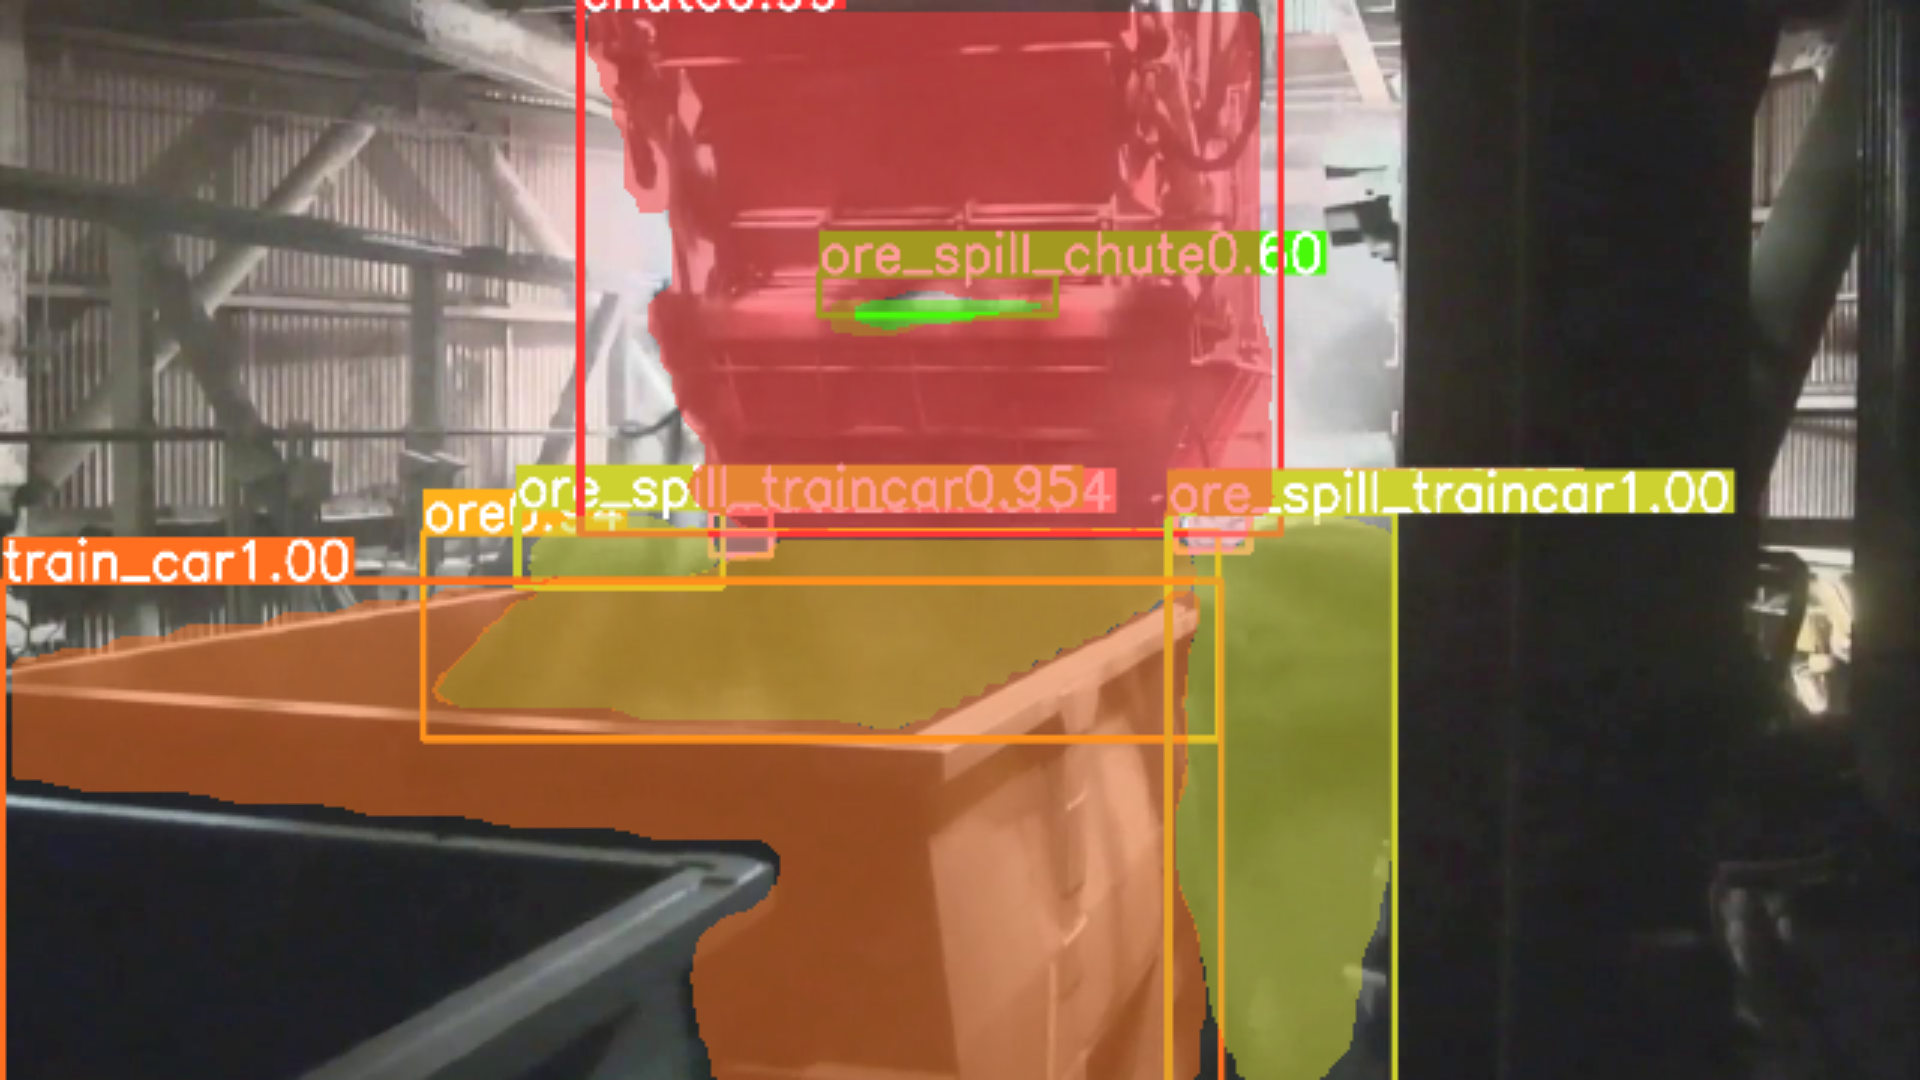

In [10]:
seg_model = YOLO('best.pt')
res = seg_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

In [11]:
from pathlib import Path

SEG_MODEL_NAME = "best"
# instance segmentation model
seg_model_path = Path(f"{SEG_MODEL_NAME}_openvino_model/{SEG_MODEL_NAME}.xml")
if not seg_model_path.exists():
    seg_model.export(format="openvino", dynamic=True, half=False)

In [21]:
from typing import Tuple
from ultralytics.yolo.utils import ops
import torch
import numpy as np


def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (640, 640), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    
    # resize
    img = letterbox(img0)[0]
    
    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

def postprocess(
    pred_boxes:np.ndarray, 
    input_hw:Tuple[int, int], 
    orig_img:np.ndarray, 
    min_conf_threshold:float = 0.25, 
    nms_iou_threshold:float = 0.7, 
    agnosting_nms:bool = False, 
    max_detections:int = 300,
    pred_masks:np.ndarray = None,
    retina_mask:bool = False
):
    
    nms_kwargs = {"agnostic": agnosting_nms, "max_det":max_detections}
    # if pred_masks is not None:
    #     nms_kwargs["nm"] = 32
    
    #pdb.set_trace()
    preds = ops.non_max_suppression(
        torch.from_numpy(pred_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        nc=6,
        **nms_kwargs
    )
    results = []
    proto = torch.from_numpy(pred_masks) if pred_masks is not None else None

    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        if proto is None:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            results.append({"det": pred})
            continue
        if retina_mask:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            masks = ops.process_mask_native(proto[i], pred[:, 6:], pred[:, :4], shape[:2])  # HWC
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        else:
            masks = ops.process_mask(proto[i], pred[:, 6:], pred[:, :4], input_hw, upsample=True)
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        results.append({"det": pred[:, :6].numpy(), "segment": segments})
    return results

def detect(image:np.ndarray, model:Model):
    
    num_outputs = len(model.outputs)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)
    boxes = result[model.output(0)]
    masks = None
    if num_outputs > 1:
        masks = result[model.output(1)]
    input_hw = input_tensor.shape[2:]
    #pdb.set_trace()
    detections = postprocess(pred_boxes=boxes, input_hw=input_hw, orig_img=image, pred_masks=masks, nms_iou_threshold=0.01)
    return detections

In [22]:
core = Core()
seg_ov_model = core.read_model(seg_model_path)
device = "CPU"
seg_compiled_model = core.compile_model(seg_ov_model, device)

start = time.time()

input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, seg_compiled_model)[0]
label_map = seg_model.model.names
image_with_masks = draw_results(detections, input_image, label_map)

end = time.time()

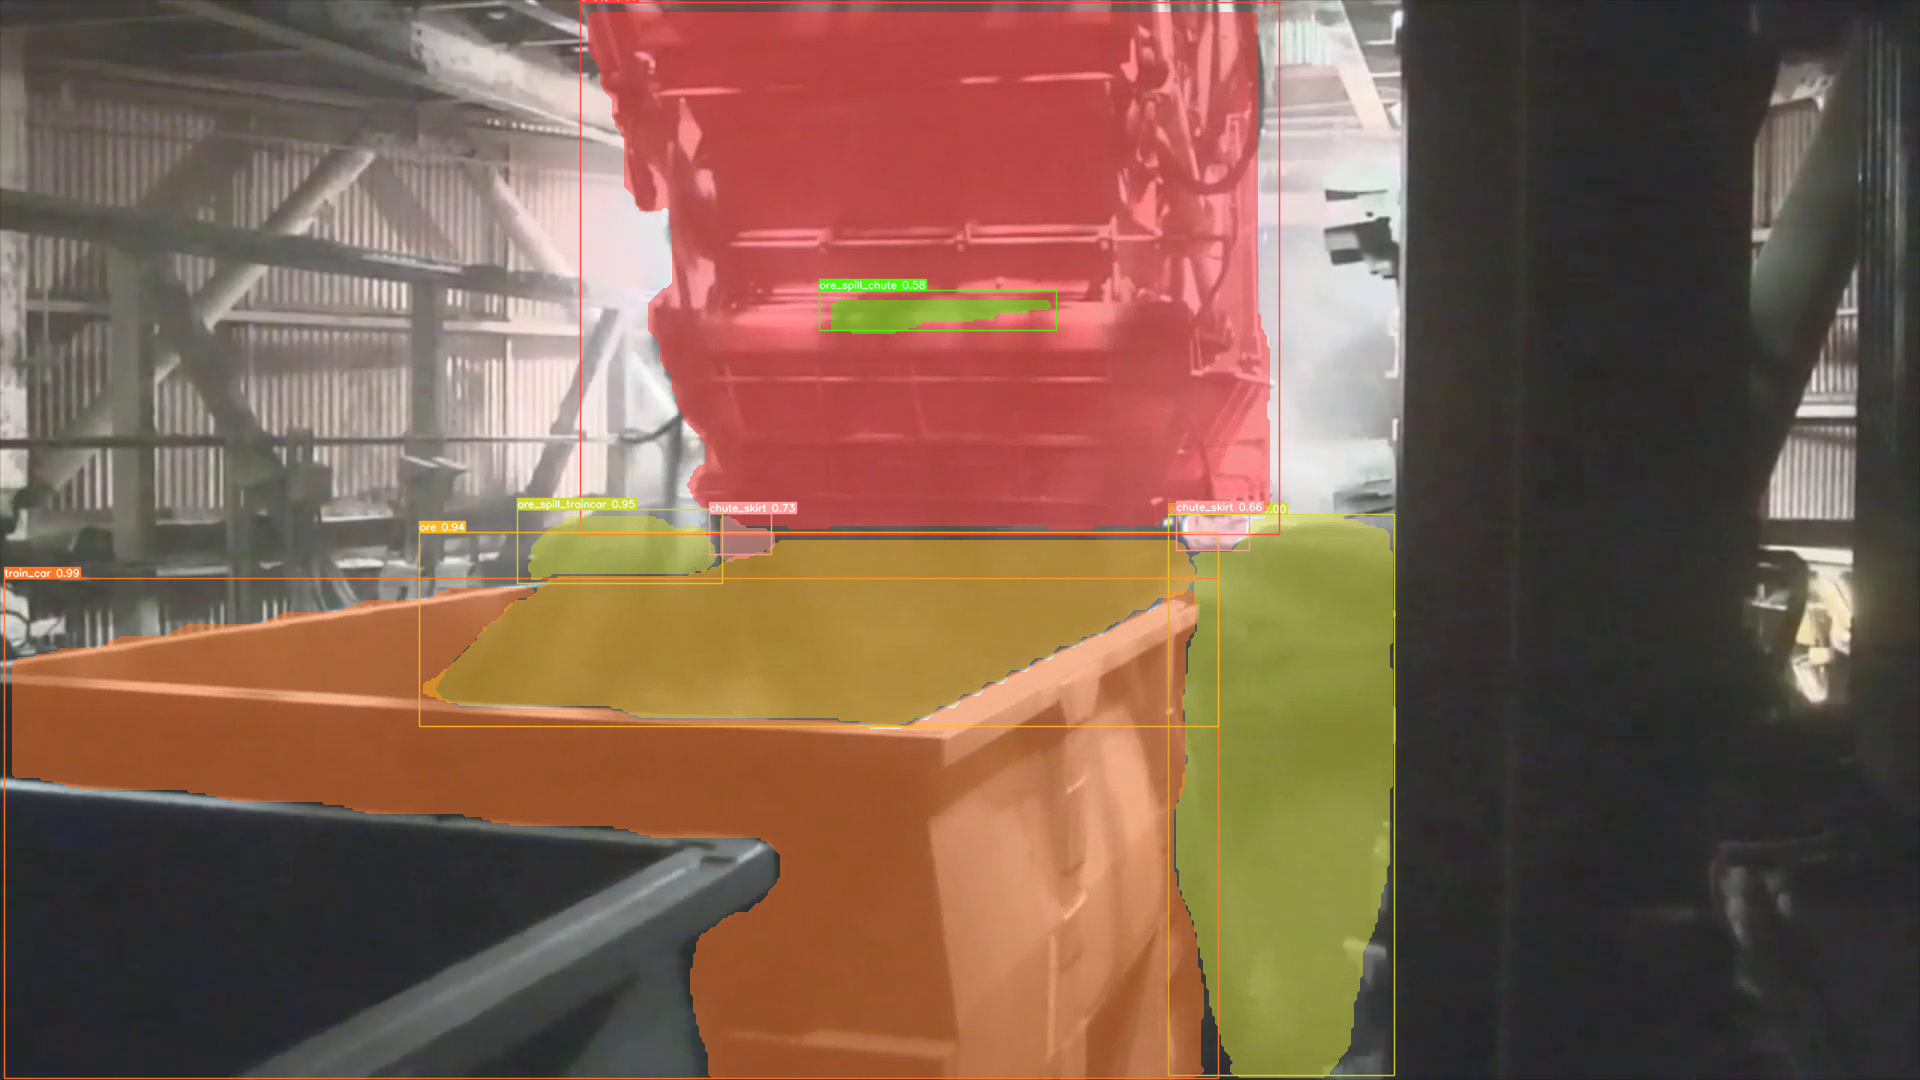

In [23]:
Image.fromarray(image_with_masks)

In [24]:
print("The time of execution of above program is :", (end-start) * 10**3, "ms")

The time of execution of above program is : 87.60643005371094 ms
